# 04_CODAmooring


In [1]:
%load_ext autoreload
%autoreload 2

import numpy.ma as ma
import numpy as np
import xarray as xr
import pandas as pd

from datetime import datetime, timedelta

import cmocean
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature


from matplotlib.dates import MonthLocator, DateFormatter, DayLocator
from matplotlib.ticker import NullFormatter
import matplotlib.dates as mdates

import metpy
from metpy.units import units

import sys

# path to own functions
sys.path.append('../../')
import data_UniBremen.SIC as UNISIC
import data_UniBremen.MultiYearIce as UNIMYI

import data_NSIDC.icedrift as PPdrift



sys.path.append('../../Libraries_functions/')
from LIB_plotting import (add_colorbar)

In [2]:

def running_mean(series, length = 3, center=False):
    
    # copy data
    variable = np.copy(series)
    running_sum = np.copy(variable)

    # end values are nans
    if center:
        running_sum[:length] = np.nan
        running_sum[-length:] = np.nan
        for ii in range(length, len(running_sum)-length):
            running_sum[ii] = np.sum(variable[ii-length:ii+length+1]) / len(variable[ii-length:ii+length+1])
        
    else:
        running_sum[:length] = np.nan
        for ii in range(length, len(running_sum)):
            running_sum[ii] = np.sum(variable[ii-length:ii+1]) / len(variable[ii-length:ii+1])
        
        
    return running_sum


# Import CODA mooring data

In [3]:
ds = {}

ds['2P1'] = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/CODA_moorings/S2P1.nc')
ds['2P1'].close()

ds['2A1'] = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/CODA_moorings/S2A1.nc')
ds['2A1'].close()

labels = {}
labels['2P1'] = '2 inshore'
labels['2A1'] = '2 offshore'

#============
site = '2A1'
#============

site_lat = ds[site].lat_lagrangian[0].values
site_lon = ds[site].lon_lagrangian[0].values

print(site_lat, site_lon)

70.77422 -149.47707


# Import ERA5 data

In [4]:
lat_local = slice(71.85, 70.35)
lon_local = slice(-156.5, -149)

# geostrophic wind components
# DS2 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourlyJFM_pressure/JFM_pressure_2020.nc')
DS2 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourlyJFM_pressure/pressure_20192020.nc')
DS2.close()
DS2
crop_DS = DS2.sel(pressure_level = 1000).z
crop_DS = crop_DS.rename({'valid_time': 'time'})

In [5]:
# DS3 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2020.nc')
# DS3.close()
# DS3.msl


In [6]:
(Ug, Vg) = metpy.calc.geostrophic_wind(crop_DS)

In [7]:

# #========================================================
time_range = [datetime(2020, 1, 1), datetime(2020, 4, 1)]
# #========================================================


#========================================================
# time_range = [datetime(2019, 11, 13), datetime(2020, 6, 1)]
#========================================================


# #========================================================
# time_range = [datetime(2020, 3, 12), datetime(2020, 3, 26)]
# #========================================================


# #========================================================
# time_range = [datetime(2020, 2, 15), datetime(2020, 3, 5)]
# #========================================================


In [8]:
ug_slice = Ug.sel(time = slice(*time_range), latitude=lat_local, longitude = lon_local)[:-1]
vg_slice = Vg.sel(time = slice(*time_range), latitude=lat_local, longitude = lon_local)[:-1]
# Z_slice = Z.sel(time = slice(*time_range), latitude=lat_local, longitude = lon_local)#[:-1]
# MSL_slice = DS3.msl.sel(time = slice(*time_range), latitude=lat_local, longitude = lon_local)[#:-1]

ug = ug_slice.mean(dim=['latitude', 'longitude'])#[:-1]
vg = vg_slice.mean(dim=['latitude', 'longitude'])#[:-1]
# z = Z_slice.mean(dim=['latitude', 'longitude'])
# msl = MSL_slice.mean(dim=['latitude', 'longitude'])/100

In [9]:
hourly_sealevel = (ds[site].sel(time=slice(*time_range)).depth.resample(time='1H').mean())
hourly_times = hourly_sealevel.time

In [10]:
    
length = 12 # hours
lvl_smooth = running_mean(hourly_sealevel, length = length, center=True)
ug_smooth = running_mean(ug, length = length, center=True)
vg_smooth = running_mean(vg, length = length, center=True)
# z_smooth = running_mean(z, length = length, center=True)
# msl_smooth = running_mean(msl, length = length, center=True)


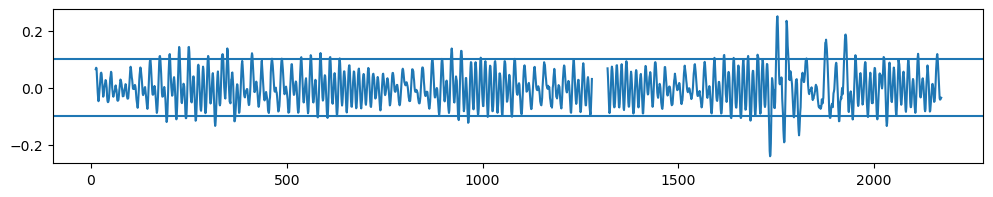

In [11]:
fig, ax = plt.subplots(figsize=(12,2))
plt.plot(hourly_sealevel-lvl_smooth)
plt.axhline(-0.1)
plt.axhline(0.1)

max R @ lag 13 hours: R = 0.81596
12-hour lag: R = 0.81556


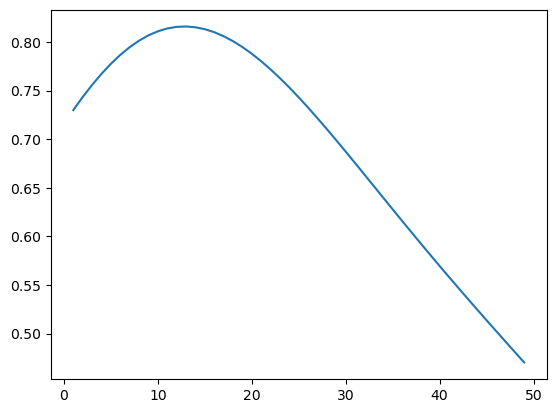

In [12]:
from scipy import stats

lags = np.arange(1, 50)
Rs = np.array([])
slopes = np.array([])
intercepts = np.array([])

for lag in lags:
    
    x = ug_smooth[:-lag]
    y = lvl_smooth[lag:]

    x_nn = x[np.isfinite(x)&np.isfinite(y)]
    y_nn = y[np.isfinite(x)&np.isfinite(y)]

    res = stats.linregress(x_nn, y_nn)
    
    Rs = np.append(Rs, res.rvalue)
    slopes = np.append(slopes, res.slope)
    intercepts = np.append(intercepts, res.intercept)

plt.plot(lags, Rs,)
print(f'max R @ lag {lags[np.argmax(Rs)]} hours: R = {np.max(Rs):.5f}')


HOUR = 12
R12hrlag = Rs[np.where(lags==HOUR)[0][0]]
sl12hrlag = slopes[np.where(lags==HOUR)[0][0]]
in12hrlag = intercepts[np.where(lags==HOUR)[0][0]]
print(f'12-hour lag: R = {R12hrlag:.5f}')

In [21]:
flaw_color = [0.6,0.775,1]
lfbo_color = [1,0.8,0.5]

lfbo_color = [1, 0.725, 0.425]
flaw_color = [0.575, 0.75, 1]

plt.rcParams.update({'font.size': 12})

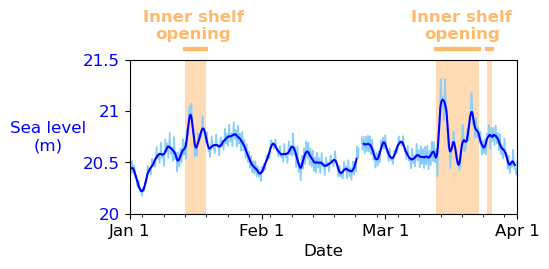

In [58]:

fig, ax = plt.subplots(figsize=(5,2))


ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b 1'))  
ax.set_xlim(*time_range)


ax.set_xlim(time_range)

# plt.ylim(13.7,15.4)

plt.ylim(20,21.5)

color1 = 'lightskyblue'# [0.7,0.7,0.7]
color = 'blue'
ax.plot(hourly_times, hourly_sealevel, c=color1, lw=1)
ax.plot(hourly_times, lvl_smooth, c=color)
ax.set_ylabel('Sea level\n(m)', rotation=0, labelpad=25, va='center', c=color)
ax.set_yticks([20,20.5,21,21.5])
ax.set_yticklabels([20,20.5,21,21.5], c=color)
ax.set_xlabel('Date')

# label inner shelf opening events
#---------------------------------
top1 = 21.6
top2 = 21.7
color = lfbo_color #[0.5, 0.5, 0.5]
for date in events['lfbo_open']['date']: 
    ax.plot([date, date+timedelta(hours=24)], [top1,top1], c=color, lw=3, clip_on=False)
    ax.fill_between([date, date+timedelta(hours=24)], *ax.get_ylim(),  color=color,  
                    edgecolor='None', alpha=0.5, zorder=-1)
ax.text( datetime(2020,1,16), top2, 'Inner shelf\nopening', ha='center', weight='bold', color=color,  clip_on=False)
ax.text( datetime(2020,3,19), top2, 'Inner shelf\nopening', ha='center', weight='bold', color=color,  clip_on=False)
        
# for date in events['flaw_open']['date']: 
#     ax.plot([date, date+timedelta(hours=24)], [21.6,21.6], c=flaw_color, lw=3, clip_on=False)
# ax.text(date, top2, 'OUTER', ha='center', weight='bold', color=flaw_color,  clip_on=False)
      
# label peaks
#------------
# ti = 1734
# tf = 1753
# color = 'k'
# size = 60
# ax.scatter(hourly_times[tf], hourly_sealevel[tf], s=size, c=color, marker='*', zorder=100)
# # ax.text(hourly_times[tf], hourly_sealevel[tf], f'{hourly_sealevel[tf]:.1f} m  ', c=color, ha='right', va='center', zorder=100)
# ta = 348
# ax.scatter(hourly_times[ta], hourly_sealevel[ta], s=size, c=color, marker='*', zorder=100)
# # ax.text(hourly_times[ta], hourly_sealevel[ta], f'  {hourly_sealevel[ta]:.1f} m', c=color, ha='left', va='center', zorder=100)
# tb = 1928
# ax.scatter(hourly_times[tb], hourly_sealevel[tb], s=size, c=color, marker='*', zorder=100)


# ax2 = ax.twinx()

# lag = HOUR
# color = [0.1,0.1,0.1]
# # ax2.plot(ug.time[lag:], ug_smooth[:-lag], c=color)
# ax2.plot(ug.time, ug_smooth, c=color)

# ymax = (ax.get_ylim()[1]-in12hrlag)/sl12hrlag
# ymin = (ax.get_ylim()[0]-in12hrlag)/sl12hrlag
# ax2.set_ylim(ymin,ymax)
# ax2.set_yticks([-20,0,20,40])
# ax2.set_yticklabels(ax2.get_yticks(), c=color)
# ax2.set_ylabel('\nZonal\nwind\n($\mathrm{m\;s^{-1}}$)', rotation=0, labelpad=25, va='center', c=color)
# ax.text(0.315, 0.7, f'R={R12hrlag:.3f}\n(12-hour lag)',c=color, transform=ax.transAxes)
# # ax.text(0.315, 0.65, f'(lag 12 hrs)', transform=ax.transAxes)


fig.savefig('./figures/CODAmooringdata_v5.png', dpi=500, bbox_inches='tight', pad_inches=0)


In [264]:
0.01965 * 36

0.7074

In [263]:
0.0206 * 36

0.7416

In [260]:
sl12hrlag

0.020638132098955157

In [261]:
in12hrlag

14.37089937710793

In [249]:
sl12hrlag

0.01965769473911623

In [248]:
in12hrlag

20.56214083317229

In [ ]:
ax.plot(np.array([pd.to_datetime(hourly_times[ti]), pd.to_datetime(hourly_times[tf])]), 
     73         np.array([hourly_sealevel[ti], hourly_sealev

In [33]:
np.nanmax(ug_smooth) - np.nanmin(ug_smooth)

36.03959479695753

In [27]:
res

LinregressResult(slope=0.010980716219976972, intercept=20.585733007027194, rvalue=0.470294604573937, pvalue=1.6214896568785297e-114, stderr=0.0004528922395402943, intercept_stderr=0.0029298632118348387)

In [34]:
sl12hrlag * 36

0.7076770106081842

In [186]:
ds2 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc')
ds2.close()

dscrop = ds2.sel(lat=slice(70.25,71), lon=slice(-150,-149))
dscrop


lat_ind = np.argmin(abs(dscrop.lat.values - site_lat))
lon_ind = np.argmin(abs(dscrop.lon.values - site_lon))

nearest_depth = dscrop.elevation[lat_ind,lon_ind].values
print(nearest_depth)

buffer = 10
lats_range = dscrop.lat.values[lat_ind-buffer:lat_ind+buffer+1]
print(f'lats: {np.min(lats_range)} -- {np.max(lats_range)}')
lons_range = dscrop.lon.values[lon_ind-buffer:lon_ind+buffer+1]
print(f'lons: {np.min(lons_range)} -- {np.max(lons_range)}')
range_depth = np.nanmean(dscrop.elevation[lat_ind-buffer:lat_ind+buffer+1,lon_ind-buffer:lon_ind+buffer+1].values)
print(range_depth)


# sp = 5
# elongrid, elatgrid = np.meshgrid(dscrop.lon[::sp], dscrop.lat[::sp])
# elevations = dscrop.elevation.values[::sp, ::sp]

-19
lats: 70.73124999999999 -- 70.81458333333333
lons: -149.51875 -- -149.43541666666667
-19.26984126984127


# import events data

In [15]:
months = [1,2,3]
years = np.append(np.arange(2003,2012),np.arange(2013,2025))

events = {}

events['lfbo_open'] = {}
events['lfbo_distinct'] = {}
events['lfbo'] = {}
events['flaw_open'] = {}
events['flaw_distinct'] = {}
events['flaw'] = {}
events['clim'] = {}

version = 'v11'
events['lfbo']['date'] = pd.to_datetime(pd.read_csv(f'../data/lfbo_new_{version}.csv').dates.values)
events['lfbo']['area'] = pd.read_csv(f'../data/lfbo_new_{version}.csv').area.values

events['lfbo_open']['date'] = pd.to_datetime(pd.read_csv(f'../data/lfbo_open_{version}.csv').dates.values)
events['lfbo_open']['area'] = pd.read_csv(f'../data/lfbo_open_{version}.csv').area.values

events['lfbo_distinct']['date'] = pd.to_datetime(pd.read_csv(f'../data/lfbo_distinct_{version}.csv').dates.values)
events['lfbo_distinct']['area'] = pd.read_csv(f'../data/lfbo_distinct_{version}.csv').area.values

events['flaw']['date'] = pd.to_datetime(pd.read_csv(f'../data/flaw_new_{version}.csv').dates.values)
events['flaw']['area'] = pd.read_csv(f'../data/flaw_new_{version}.csv').area.values

events['flaw_open']['date'] = pd.to_datetime(pd.read_csv(f'../data/flaw_open_{version}.csv').dates.values)
events['flaw_open']['area'] = pd.read_csv(f'../data/flaw_open_{version}.csv').area.values

events['flaw_distinct']['date'] = pd.to_datetime(pd.read_csv(f'../data/flaw_distinct_{version}.csv').dates.values)
events['flaw_distinct']['area'] = pd.read_csv(f'../data/flaw_distinct_{version}.csv').area.values

# record across other dates to so as not to cut off events occurring 
# at time domain bounds
record_all = {}
record_all['lfbo'] = np.copy(events['lfbo']['date'])
record_all['flaw'] = np.copy(events['flaw']['date'])
record_all['lfbo_open'] = np.copy(events['lfbo_open']['date'])
record_all['flaw_open'] = np.copy(events['flaw_open']['date'])



for cat in ['lfbo_open', 'lfbo', 'flaw', 'flaw_open', 'flaw_distinct', 'lfbo_distinct']:
    events[cat]['area'] = events[cat]['area'][(events[cat]['date'].month<4)&(events[cat]['date'].year==2020)]
    events[cat]['date'] = events[cat]['date'][(events[cat]['date'].month<4)&(events[cat]['date'].year==2020)]

# save clime dates
clim_dates = np.array([], dtype='datetime64[ns]')
for year in years:
    clim_dates = np.append(clim_dates, pd.date_range(datetime(year, 1, 1), datetime(year, 3, 31)))
clim_dates = pd.to_datetime(clim_dates)
print(f'{len(clim_dates)} clim_dates')
    
events['clim']['date'] = clim_dates


1895 clim_dates


In [271]:
events['lfbo_open']['date']

DatetimeIndex(['2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17',
               '2020-01-18', '2020-03-13', '2020-03-14', '2020-03-15',
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-25'],
              dtype='datetime64[ns]', freq=None)